# Telco Churned Customers Prediction Model



### 1. Import necessary libraries:

In [ ]:
# Install necessary libraries.
#!pip install keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.datasets import load_files
from collections import Counter
from numpy import where
from sklearn import preprocessing
from imblearn.over_sampling import ADASYN   # for unbalanced data 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
import keras
import keras.utils
from keras.models import Model                       # We will use Functional API.
from keras.layers import Dense, Input 
from keras.optimizers import Adam
from sklearn.metrics import classification_report
import warnings   

               
warnings.filterwarnings('ignore')                    # Turn the warnings off.
%matplotlib inline

In [2]:
# use GPU after activate from the notebook settings
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

UsageError: Line magic function `%tensorflow_version` not found.


In [ ]:
#Import the dataset to colab files from githup
!git clone https://github.com/saraMuay/Churned_Customer_Project.git

#### 1.1. Read in the data:

More information about the dataset can be found [here](https://community.ibm.com/accelerators/?context=analytics&query=telco%20churn&type=Data&product=Cognos%20Analytics).

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/saraMuay/Churned_Customer_Project/main/Telco_customer_churn.csv')
data.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [6]:
data.shape

(7043, 33)

#### 1.2. Perform EDA:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

#### 2. Data Preprocessing:

##### 2.1 Drop Unnecessary Columns:

In [8]:
# correct columns names to avoid any error related to it.
data.columns = [c.replace(' ', '_') for c in data.columns]

In [9]:
#Removing unnecessary columns
data = data.drop(columns = ['CustomerID', 'Count','Country','State', 'City','Zip_Code','Lat_Long','Latitude','Longitude'
                            ,'Paperless_Billing','Total_Charges','Churn_Label','Churn_Score','CLTV', 'Churn_Reason'])
data

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Payment_Method,Monthly_Charges,Churn_Value
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Mailed check,53.85,1
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check,70.70,1
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Electronic check,99.65,1
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Electronic check,104.80,1
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Bank transfer (automatic),103.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Bank transfer (automatic),21.15,0
7039,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Mailed check,84.80,0
7040,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Credit card (automatic),103.20,0
7041,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Electronic check,29.60,0


In [10]:
data.shape

(7043, 18)

In [11]:
data['Churn_Value'].value_counts()

0    5174
1    1869
Name: Churn_Value, dtype: int64

we observed Unbalanced classes which lead us to handel.


In [12]:
# % of the churn 
data.groupby('Churn_Value').size() / len(data)*100

Churn_Value
0    73.463013
1    26.536987
dtype: float64

##### 2.2 Data Visualization

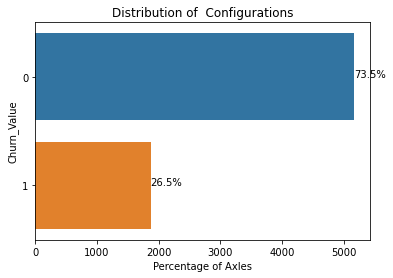

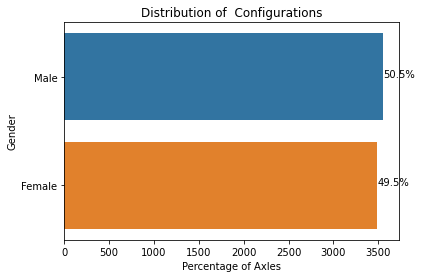

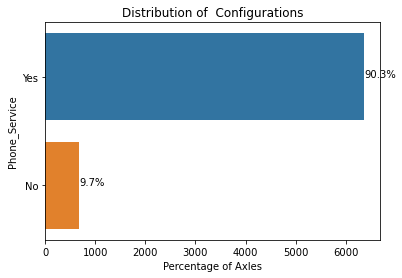

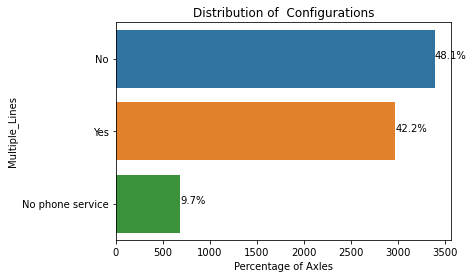

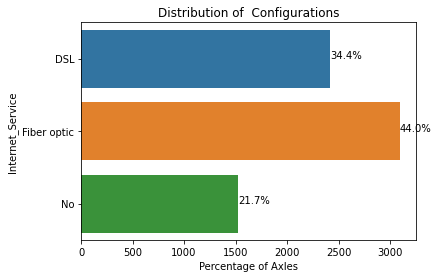

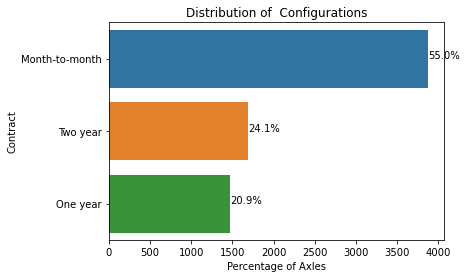

In [17]:
#  better understanding the original data

def bar_plot(df,column):    
    ax = sns.countplot(y=column, data=df)
    plt.title('Distribution of  Configurations')
    plt.xlabel('Percentage of Axles')
    total = len(df[column])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    plt.show()
bar_plot(data, "Churn_Value")
bar_plot(data, "Gender")
bar_plot(data, "Phone_Service")
bar_plot(data, "Multiple_Lines")
bar_plot(data, "Internet_Service")
bar_plot(data, "Contract")

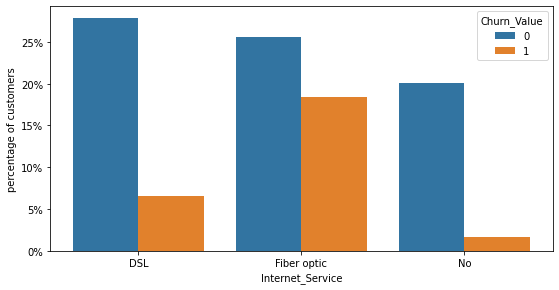

 Customer with Fiber optic Internet more likly to Churn


In [18]:
def barplot_percentages(f, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = data.groupby(f)["Churn_Value"].value_counts().to_frame()
    g = g.rename({"Churn_Value": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(data)
    if orient == 'v':
        ax = sns.barplot(x=f, y= axis_name, hue='Churn_Value', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=f, hue='Churn_Value', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()

plt.figure(figsize=(9, 4.5))

barplot_percentages('Internet_Service')
plt.show()
print(' Customer with Fiber optic Internet more likly to Churn')


Customer how has Fiber optic Internet more likly to Churn

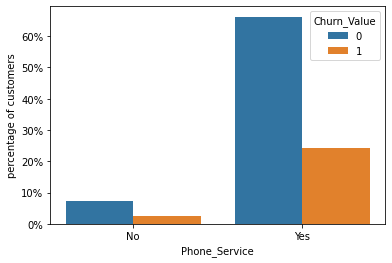

In [19]:
barplot_percentages('Phone_Service')
plt.show()

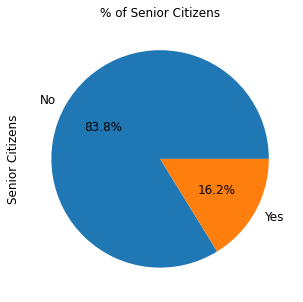

In [20]:

ax = (data['Senior_Citizen'].value_counts()*100.0 /len(data))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)
plt.show()

Most of the customer are young

##### 2.3 Convert categorical columns to Numeric by using one_ hot Encoding :

In [21]:
# Create Dummies Variable
data = pd.get_dummies(data, drop_first=True)

In [22]:
data.head()

,Tenure_Months,Monthly_Charges,Churn_Value,Gender_Male,Senior_Citizen_Yes,Partner_Yes,Dependents_Yes,Phone_Service_Yes,Multiple_Lines_No phone service,Multiple_Lines_Yes,...,Tech_Support_Yes,Streaming_TV_No internet service,Streaming_TV_Yes,Streaming_Movies_No internet service,Streaming_Movies_Yes,Contract_One year,Contract_Two year,Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,2,53.85,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,70.70,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,8,99.65,1,0,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,1,0
3,28,104.80,1,0,0,1,1,1,0,1,...,1,0,1,0,1,0,0,0,1,0
4,49,103.70,1,1,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0


##### 2.4 Drop high correlation Columns:

In [23]:
# Visualize the corrolation 
data.corr().style.background_gradient(cmap='cividis')

,Tenure_Months,Monthly_Charges,Churn_Value,Gender_Male,Senior_Citizen_Yes,Partner_Yes,Dependents_Yes,Phone_Service_Yes,Multiple_Lines_No phone service,Multiple_Lines_Yes,Internet_Service_Fiber optic,Internet_Service_No,Online_Security_No internet service,Online_Security_Yes,Online_Backup_No internet service,Online_Backup_Yes,Device_Protection_No internet service,Device_Protection_Yes,Tech_Support_No internet service,Tech_Support_Yes,Streaming_TV_No internet service,Streaming_TV_Yes,Streaming_Movies_No internet service,Streaming_Movies_Yes,Contract_One year,Contract_Two year,Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
Tenure_Months,1.000000,0.247900,-0.352229,0.005106,0.016567,0.379697,0.131376,0.008448,-0.008448,0.331941,0.019720,-0.039062,-0.039062,0.327203,-0.039062,0.360277,-0.039062,0.360653,-0.039062,0.324221,-0.039062,0.279756,-0.039062,0.286111,0.202570,0.558533,0.233006,-0.208363,-0.233852
Monthly_Charges,0.247900,1.000000,0.193356,-0.014569,0.220173,0.096848,-0.144206,0.247398,-0.247398,0.490434,0.787066,-0.763557,-0.763557,0.296594,-0.763557,0.441780,-0.763557,0.482692,-0.763557,0.338304,-0.763557,0.629603,-0.763557,0.627429,0.004904,-0.074681,0.030550,0.271625,-0.377437
Churn_Value,-0.352229,0.193356,1.000000,-0.008612,0.150889,-0.150448,-0.248542,0.011942,-0.011942,0.040102,0.308020,-0.227890,-0.227890,-0.171226,-0.227890,-0.082255,-0.227890,-0.066160,-0.227890,-0.164674,-0.227890,0.063228,-0.227890,0.061382,-0.177820,-0.302253,-0.134302,0.301919,-0.091683
Gender_Male,0.005106,-0.014569,-0.008612,1.000000,-0.001874,-0.001808,0.005229,-0.006488,0.006488,-0.008414,-0.011286,0.006026,0.006026,-0.017021,0.006026,-0.013773,0.006026,-0.002105,0.006026,-0.009212,0.006026,-0.008393,0.006026,-0.010487,0.008026,-0.003695,0.001215,0.000752,0.013744
Senior_Citizen_Yes,0.016567,0.220173,0.150889,-0.001874,1.000000,0.016479,-0.174396,0.008576,-0.008576,0.142948,0.255338,-0.182742,-0.182742,-0.038653,-0.182742,0.066572,-0.182742,0.059428,-0.182742,-0.060625,-0.182742,0.105378,-0.182742,0.120176,-0.046262,-0.117000,-0.024135,0.171718,-0.153477
Partner_Yes,0.379697,0.096848,-0.150448,-0.001808,0.016479,1.000000,0.363430,0.017706,-0.017706,0.142057,0.000304,0.000615,0.000615,0.143106,0.000615,0.141498,0.000615,0.153786,0.000615,0.119999,0.000615,0.124666,0.000615,0.117412,0.082783,0.248091,0.082029,-0.083852,-0.095125
Dependents_Yes,0.131376,-0.144206,-0.248542,0.005229,-0.174396,0.363430,1.000000,0.000625,-0.000625,-0.027510,-0.162353,0.172110,0.172110,0.050353,0.172110,0.003457,0.172110,-0.022343,0.172110,0.028811,0.172110,-0.057717,0.172110,-0.073364,0.014680,0.190262,0.041254,-0.141476,0.071056
Phone_Service_Yes,0.008448,0.247398,0.011942,-0.006488,0.008576,0.017706,0.000625,1.000000,-1.000000,0.279690,0.289999,0.172209,0.172209,-0.092893,0.172209,-0.052312,0.172209,-0.071227,0.172209,-0.096340,0.172209,-0.022574,0.172209,-0.032959,-0.002791,0.003519,-0.007721,0.003062,-0.003319
Multiple_Lines_No phone service,-0.008448,-0.247398,-0.011942,0.006488,-0.008576,-0.017706,-0.000625,-1.000000,1.000000,-0.279690,-0.289999,-0.172209,-0.172209,0.092893,-0.172209,0.052312,-0.172209,0.071227,-0.172209,0.096340,-0.172209,0.022574,-0.172209,0.032959,0.002791,-0.003519,0.007721,-0.003062,0.003319
Multiple_Lines_Yes,0.331941,0.490434,0.040102,-0.008414,0.142948,0.142057,-0.027510,0.279690,-0.279690,1.000000,0.366083,-0.210564,-0.210564,0.098108,-0.210564,0.202237,-0.210564,0.201137,-0.210564,0.100571,-0.210564,0.257152,-0.210564,0.258751,-0.003794,0.106253,0.060048,0.083618,-0.227206


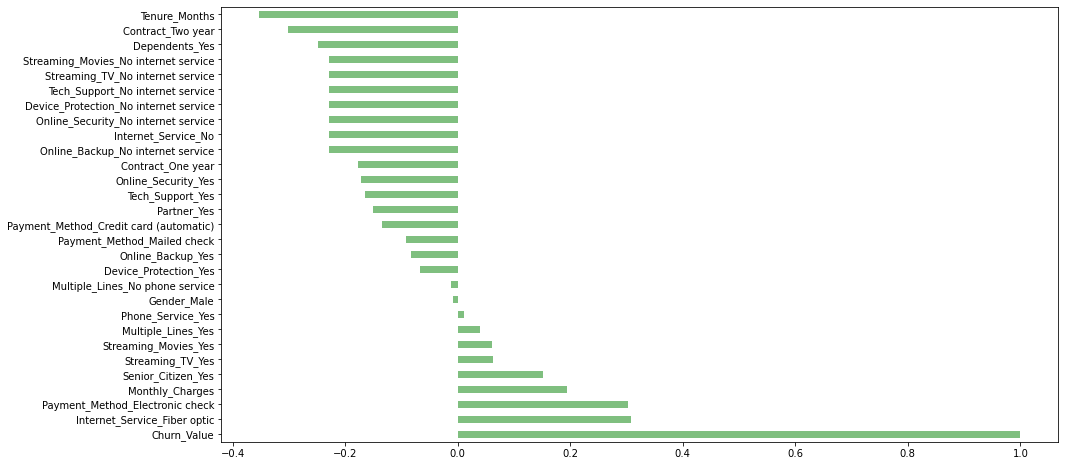

In [24]:
# Visualize the corrolation base on churn 
plt.figure(figsize=(15,8))
data.corr()['Churn_Value'].sort_values(ascending = False).plot(kind='barh', color ='g', alpha= 0.5)
plt.show()

In [25]:
#Removing the high correlation features
data = data.drop(columns = ['Multiple_Lines_No phone service', 'Internet_Service_No','Online_Security_No internet service',
                              'Online_Backup_No internet service','Device_Protection_No internet service',
                              'Tech_Support_No internet service','Streaming_TV_No internet service',
                            'Streaming_Movies_No internet service'
                            ])

In [26]:
data.shape

(7043, 21)

####  Visualize the Data After Features Engineer:

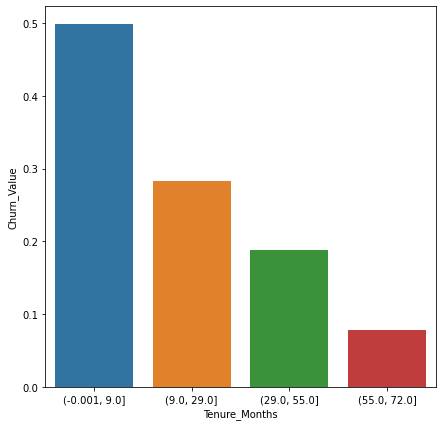

In [29]:
 # visualize the data after feature engineer
plt.figure(figsize=(7,7))
w = pd.qcut(data.Tenure_Months,4)
sns.barplot(x=w ,y='Churn_Value', ci=None, data=data)
plt.show()

New clients are more likely to churn

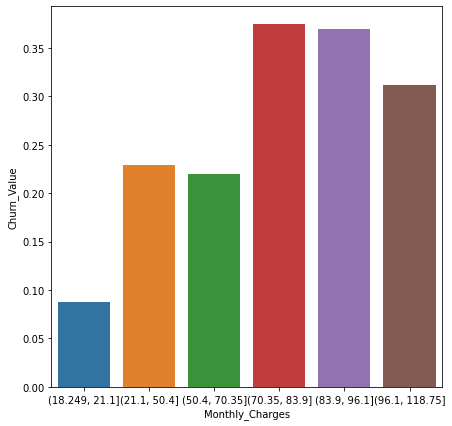

In [30]:
plt.figure(figsize=(7,7))
w = pd.qcut(data.Monthly_Charges,6)                   
sns.barplot(x= w,y='Churn_Value', ci=None, data=data)
plt.show()

Clients with higher Monthly Charges are also more likely to churn

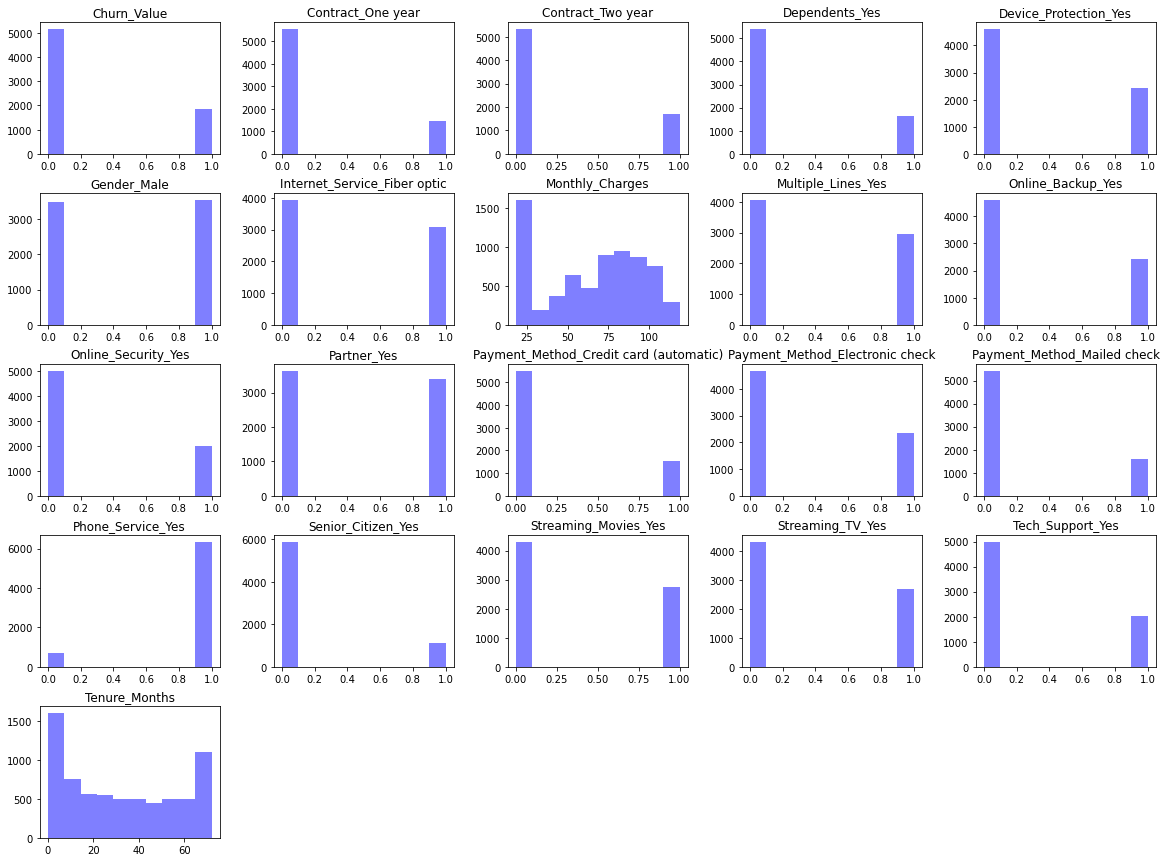

In [31]:
data.hist(figsize=(20,15), color = 'b', alpha= 0.5 ,grid= False)
plt.show()

#### 2.5 Determine the Data  Target :

In [32]:
# Creating X features, Y responce varible
X = data.drop(columns=['Churn_Value'])
Y = data.Churn_Value
Y

0       1
1       1
2       1
3       1
4       1
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: Churn_Value, Length: 7043, dtype: int64

In [33]:
X.loc[[7042]]

,Tenure_Months,Monthly_Charges,Gender_Male,Senior_Citizen_Yes,Partner_Yes,Dependents_Yes,Phone_Service_Yes,Multiple_Lines_Yes,Internet_Service_Fiber optic,Online_Security_Yes,Online_Backup_Yes,Device_Protection_Yes,Tech_Support_Yes,Streaming_TV_Yes,Streaming_Movies_Yes,Contract_One year,Contract_Two year,Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
7042,66,105.65,1,0,0,0,1,0,1,1,0,1,1,1,1,0,1,0,0,0


#### 2.6 Oversampling using SMOT Adasyn:

Counter({0: 5174, 1: 1869})


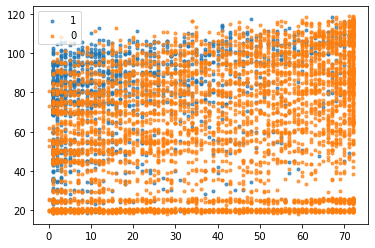

In [41]:
x_= X.to_numpy() 
y_ = Y.to_numpy() 

counter = Counter(y_)
print(counter)
# scatter plot of examples by class label

for label, _ in counter.items():
    row_ix = where(y_ == label)[0]
    plt.scatter(x_[row_ix, 0], x_[row_ix, 1], label=str(label), alpha=0.7, marker='.')
plt.legend()
plt.show()

In [42]:
# Oversampling the train dataset using ADASYN

counter_before= Counter(Y)
print('Before',counter_before) #dataset before oversampling

ada= ADASYN(random_state=130)
x, y = ada.fit_resample(X,Y)

counter_after = Counter(y)

print('After',counter_after) #dataset after oversampling

Before Counter({0: 5174, 1: 1869})
After Counter({0: 5174, 1: 5128})


In [43]:
counter = Counter(y)
print(counter)
# scatter plot of examples by class label

for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(x[row_ix, 0], x[row_ix, 1], label=str(label), alpha=0.7, marker='.')
plt.legend()
plt.show()

Counter({0: 5174, 1: 5128})


TypeError: '(array([    0,     1,     2, ..., 10299, 10300, 10301], dtype=int64), 0)' is an invalid key

## Build the model 

#### 3.1 Train & test set


In [52]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=123)

In [53]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7211, 20)
(3091, 20)
(7211,)
(3091,)


#### 3.2 Train the model & Define the hyperparameters and optimizer:

#### 3.2.A  Tree base Model 

###### A.1 Dession Tree Model :

In [46]:
depth_grid = np.arange(1,21)
min_samples_leaf_grid = np.arange(1,10) #31
max_leaf_nodes_grid = np.arange(2,10)#21
parameters = {'max_depth':depth_grid, 'min_samples_leaf':min_samples_leaf_grid, 'max_leaf_nodes':max_leaf_nodes_grid}

In [47]:
gridCV = GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, n_jobs = -1)
gridCV.fit(x_train, y_train);
best_depth = gridCV.best_params_['max_depth']
best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']
best_max_leaf_nodes = gridCV.best_params_['max_leaf_nodes']

In [48]:
print("Tree best depth : " + str(best_depth))
print("Tree best min_samples_leaf : " + str(best_min_samples_leaf))
print("Tree best max_leaf_nodes : " + str(best_max_leaf_nodes))

Tree best depth : 3
Tree best min_samples_leaf : 1
Tree best max_leaf_nodes : 4


In [55]:
DTC = DecisionTreeClassifier(max_depth=7,min_samples_leaf=30,max_leaf_nodes=20)
DTC.fit(x_train, y_train);
Y_pred = DTC.predict(x_test)
print( "Tree accuracy : % " + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

Tree accuracy : % 78.809


###### A.2 Random Forest Model :

In [ ]:
n_estimators_grid = np.arange(100, 800,50)
depth_grid = np.arange(1, 21)
min_samples_leaf_grid = np.arange(1,21)

parameters = {'n_estimators': n_estimators_grid, 'max_depth': depth_grid, 'min_samples_leaf':min_samples_leaf_grid}

gridCV = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=10, n_jobs=-1)
gridCV.fit(x_train, y_train)

In [ ]:
best_n_estim = gridCV.best_params_['n_estimators']
best_depth = gridCV.best_params_['max_depth']
best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']

print("Random Forest best n_estimator : " + str(best_n_estim))
print("Random Forest best max_depth : " + str(best_depth))
print("Random Forest best min_samples_leaf : " + str(best_min_samples_leaf))

In [ ]:
RF_best = RandomForestClassifier(n_estimators = 600 ,max_depth = 7, min_samples_leaf=20  ,random_state=123)
RF_best.fit(x_train, y_train)
Y_pred = RF_best.predict(x_test)
print( "Random Forest accuracy : %" + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

In [ ]:
# Plot features importances
imp = pd.Series(data=RF_best .feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

###### A.3 Gradient Boosting Classifier Model : 

In [ ]:
n_estimators_grid = np.arange(20, 100,2)
learn_rate =0.02*np.arange(1, 50)
max_depth = np.arange(1,20)

parameters = {'n_estimators': n_estimators_grid, 'learning_rate': learn_rate, 'max_depth':max_depth}

gridCV = GridSearchCV(GradientBoostingClassifier(), param_grid=parameters, cv=10, n_jobs=-1)
gridCV.fit(x_train, y_train)

In [ ]:
best_n_estim = gridCV.best_params_['n_estimators']
best_depth = gridCV.best_params_['max_depth']
best_learning_rate = gridCV.best_params_['learning_rate']

print("Random Forest best n_estimator : " + str(best_n_estim))
print("Random Forest best max_depth : " + str(best_depth))
print("Random Forest best min_samples_leaf : " + str(best_learning_rate))

In [ ]:
GBoost = GradientBoostingClassifier(n_estimators= 30 , learning_rate= 0.1, max_depth= 15)
GBoost.fit(x_train, y_train)
y_pred= GBoost.predict(x_test)
print( "Gradient Boosting Classifier : %" + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))
print('Gradient Boosting score', str(np.around(GBoost.score(x_test, y_test)*100,3)) )

Gradient Boosting Classifier : %82.233
Gradient Boosting score 82.686


###### A.4 Ada Boost Classifier Model:

In [ ]:
my_max_depth = 15 
my_learn_rate = 0.01                                           
n_estimators_grid = np.arange(50, 81, 2)
parameters = {'n_estimators': n_estimators_grid}
AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=my_max_depth), learning_rate=my_learn_rate)   
gridCV = GridSearchCV(AB, param_grid=parameters, cv=10, n_jobs = -1)
gridCV.fit(x_train, y_train)
best_n_estim = gridCV.best_params_['n_estimators']

In [ ]:
print("AdaBoost best n estimator : " + str(best_n_estim))

In [ ]:
AB_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15),n_estimators=55,learning_rate= 0.01,random_state=123)
AB_best.fit(x_train, y_train)
Y_pred = AB_best.predict(x_test)
print( "AdaBoost accuracy : % " + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

AdaBoost accuracy : % 84.369


###### A.5 Extreme Gradient Boosting Classification Model :

In [ ]:
n_estimators_grid = np.arange(20, 500,2)
learn_Rate = 0.02*np.arange(1, 50)
max_depth = np.arange(1,21)

parameters = {'n_estimators': n_estimators_grid, 'learning_Rate': learn_Rate, 'max_depth':max_depth}

gridCV = GridSearchCV( XGBClassifier(), param_grid=parameters, cv=10, n_jobs=-1)
gridCV.fit(x_train, y_train)

In [ ]:
best_n_estim = gridCV.best_params_['n_estimators']
best_depth = gridCV.best_params_['max_depth']
best_learning_rate = gridCV.best_params_['learning_rate']

print("Random Forest best n_estimator : " + str(best_n_estim))
print("Random Forest best max_depth : " + str(best_depth))
print("Random Forest best min_samples_leaf : " + str(best_learning_rate))

In [ ]:
# Classification by XGBoost.
XGBC = XGBClassifier(n_estimator = 500, learning_Rate = 0.001, max_depth = 10, subsample= 0.3,  random_state=123)
XGBC.fit(x_train, y_train)
Y_pred = XGBC.predict(x_test)
print( "XGBoost accuracy : %" + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

XGBoost accuracy : %86.149


###### A.6 lgbmclassifier classifier Model :

In [ ]:
LGB = lgb.LGBMClassifier()
LGB.fit(x_train, y_train)
print("LGBM Classifier Score : %",str(np.round(LGB.score(x_test, y_test)*100,3)) )
Y_pred = LGB.predict(x_test)
print( "LGBM Classifier accuracy : %" + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

LGBM Classifier Score : % 85.825
LGBM Classifier accuracy : %85.825


###### A.7 Voting Classifier

In [ ]:
DTC = DecisionTreeClassifier( max_leaf_nodes=100) 
DTC.fit(x_train, y_train)
Y_pred = DTC.predict(x_test)
print( "Tree accuracy : %" + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

Tree accuracy : %82.039


In [ ]:
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(x_train, y_train)
Y_pred = KNN.predict(x_test)
print( "KNN accuracy : %" + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

KNN accuracy : %79.644


In [ ]:
LR = LogisticRegression(solver='lbfgs',max_iter=100, C= 0.1)
LR.fit(x_train, y_train)
Y_pred = LR.predict(x_test)
print( "Logistic regression accuracy : % " + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

Logistic regression accuracy : % 73.139


In [ ]:
VC = VotingClassifier(estimators=[('Tree',DTC),('knn',KNN),('Logistic',LR)],voting='hard') 
VC.fit(x_train, y_train)
Y_pred = VC.predict(x_test)
print( "Hard Voting Classifier Accuracy : % " + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

Hard Voting Classifier Accuracy : % 81.812


In [ ]:
VC = VotingClassifier(estimators=[('Tree',DTC),('knn',KNN),('Logistic',LR)],voting='soft')
VC.fit(x_train, y_train)
Y_pred = VC.predict(x_test)
print( "Soft Voting Classifier Accuracy : % " + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

Soft Voting Classifier Accuracy : % 82.945


#### 3.2.B None Tree base Model 

###### B. Scaling the Features

In [ ]:
#Scaling for non tree model 
scaler = preprocessing.MinMaxScaler()
X= scaler.fit_transform(x)
X[0]

###### B.1 Logistic Regression:

In [ ]:

solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]

parameters = {'solver': solvers, 'max_iter' : max_iters, 'C':c_values }

gridCV = GridSearchCV(LogisticRegression(), parameters, cv=10, n_jobs= -1)              
gridCV.fit(x_train, y_train)

best_C = gridCV.best_params_['C']
best_solver = gridCV.best_params_['solver']

print ( ' best c parameter',str(best_C) )
print ( ' best solver parameter',str(best_solver) )

In [ ]:
# Train and predict.
LL = LogisticRegression(solver='lbfgs',max_iter=100, C= 0.1)
LL.fit(x_train,y_train)
y_pred_test = LL.predict(x_test) 

print (' Logistic Regression : %',np.round(metrics.accuracy_score(y_test, y_pred_test)*100 ,3))  

 Logistic Regression : % 73.139


In [ ]:
# Confusion matrix.
conf_mat = metrics.confusion_matrix(y_test,y_pred_test)
print(conf_mat)

[[1054  509]
 [ 321 1206]]


In [ ]:
roc_auc_score(y_train, LL.predict_proba(x_train)[:, 1])

print ('AUC for Logistic Regression: %', str( np.around(roc_auc_score(y_train, LL.decision_function(x_train) )*100))  )

AUC for Logistic Regression: % 83.0


###### B.2 Naive Bayes:

In [ ]:
GNB = GaussianNB()
GNB.fit(x_train,y_train)
Y_pred_test = GNB.predict(x_test)

accuracy = metrics.accuracy_score(y_test, Y_pred_test)
print('Accuracy : %' + str(np.round(accuracy*100,3)))

Accuracy : %73.43


In [ ]:
conf_mat = metrics.confusion_matrix(y_test, Y_pred_test)
print(conf_mat)

[[1032  531]
 [ 290 1237]]


###### B.3 Support Vector Machines (SVM):


In [ ]:
C_grid = 0.02*np.arange(1,20)
gamma_grid = 0.02*np.arange(1,50)
parameters = {'C': C_grid, 'gamma' : gamma_grid}
gridCV = GridSearchCV(SVC(kernel='rbf'), parameters, cv=10, n_jobs=-1)        
gridCV.fit(x_train, y_train)

best_C = gridCV.best_params_['C']
best_gamma = gridCV.best_params_['gamma']


In [ ]:
print("SVM best C : " + str(best_C))
print("SVM best gamma : " + str(best_gamma))

In [ ]:
SVM = SVC(kernel='rbf', C=3,gamma=0.41 , probability=True)
SVM.fit(x_train, y_train)
Y_pred = SVM.predict(x_test)
print( "SVM accuracy : %" + str(np.round(metrics.accuracy_score(y_test,Y_pred)*100,3)))

SVM accuracy : %88.9


In [ ]:
#probabilities to find Area Under the Curve
y_prob = SVM.predict_proba(x_test)[:,1] 
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Area Under the Curve: %',  np.around(roc_auc*100,3))

Area Under the Curve: % 94.092


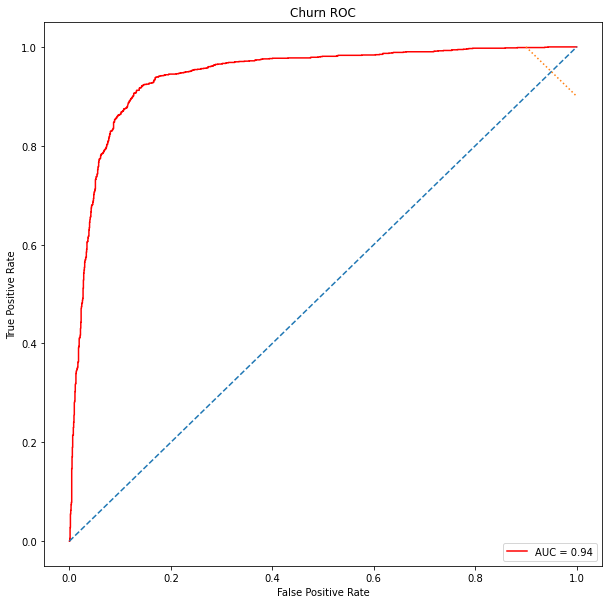

In [ ]:
# visual the AUC
plt.figure(figsize=(10,10))
plt.title('Churn ROC')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.plot([0.9, 1], [1, 0.9],linestyle=':')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# report matrix
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1563
           1       0.86      0.92      0.89      1527

    accuracy                           0.89      3090
   macro avg       0.89      0.89      0.89      3090
weighted avg       0.89      0.89      0.89      3090



###### B.4 Keras Neural Network (Logistic):

In [ ]:
n_vars = x_train.shape[1]
n_epochs = 1250
batch_size = 1000
learn_rate = 0.0005

In [ ]:
my_input = Input(shape=(n_vars,))
my_output = Dense(units=1,activation='sigmoid')(my_input)

In [ ]:
my_optimizer=Adam(lr=learn_rate)

In [ ]:
my_model=Model(inputs=my_input,outputs=my_output)

In [ ]:
los=keras.losses.BinaryCrossentropy()
my_model.compile(loss=los , optimizer=my_optimizer, metrics=['accuracy'])

In [ ]:
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_summary = my_model.fit(x_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split = 0.2, verbose = 0)

In [ ]:
my_summary.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

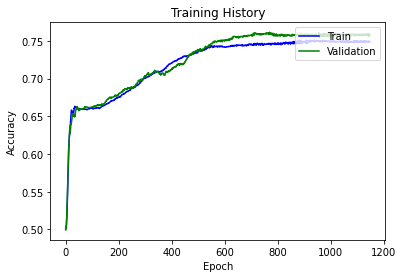

In [ ]:
n_skip = 100 
plt.plot(my_summary.history['accuracy'][n_skip:], c="b")
plt.plot(my_summary.history['val_accuracy'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
ACC = my_model.evaluate(x_test, y_test, verbose=0)[1]    
print("NN Accuracy: % {}".format(np.round(ACC*100,3)))

NN Accuracy: % 72.686


### Based on model comparisons, We observed that SVM Model has high accuracy performance with 88.9%

### Prediction Using SVM Model:

In [ ]:
y_test[1000]

0

In [ ]:
y_pred = SVM.predict(x_test)[1000]
if y_pred==0:
  print(' customer more likely to churn ')
else:
  print(' customer more likely to not churn ')

 customer more likely to churn 


In [ ]:
# Save the SVM model to external file to be used in the deployment
import pickle
pickle.dump(SVM, open('model.pkl','wb'))

In [3]:
# Below deployed model link
# https://ml-sic.000webhostapp.com/#/

---
### Conclusion:

 This project aimed to build a system that predicts the churn of customers in telecom company to help companies make more profit. Through this steps

Data preprocessing :

- Drop Unnecessary Columns
- Feature Engineer 
    - One_Hot Encoding 
    - handeld high corellation feature 
    - Dealing with Unbalanced Classes using SMOT adasyn method
- Visualization 
- Determine the data target and the features


Building the Model:
- split the data into training and testing set
- Train the model.
    - Things that help us to increase our model accuracy:
       - Tune the Hyper_parameters
       - Features Selection.
       - Apply oversampling techniques to control unbalanced classes.


- Evaluate the model using AUC 0.94 
- Report Martix 

### SVM has best accuracy model 88.9%

#### Save the SVM model to external file to be used in the deployment


---